# Import packages

In [1]:
import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), ".."))

import random
import numpy as np

import torch 
from torch import distributions
from torch import nn
from torch.utils import data

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

%reload_ext autoreload
%autoreload 2 # Reload all modueles every time before executing the Python code typed.

import project
import project.networks.net as net
from project.models.triple_well   import TripleWell

import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
import scipy.ndimage
nbins=100
from scipy.stats import kde

os.environ['KMP_DUPLICATE_LIB_OK']='True'

UsageError: unrecognized arguments: # Reload all modueles every time before executing the Python code typed.


In [2]:
np.random.seed(seed=0)
torch.manual_seed(0)
random.seed(0)

# Visualize triple well potential
We'll first visualize the triple well potential to have a reference

In [3]:
def E(x, y): # default parameter values given in pg. 4 of the SI 
    return 3 * (3 * np.exp( -x**2 - (y - (1/3))**2) - \
                3 * np.exp( -x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*x + 0.2*(y - (1/3)**4)) + 5 + 0.1 * (x**2 + y**2)

In [4]:
x_illustrate = np.linspace(-2.5,2.5,100)
y_illustrate = np.linspace(-2,3,100)
xx, yy = np.meshgrid(x_illustrate, y_illustrate, sparse=True)
E_illustrate = E(xx,yy)

fig = go.Figure(data =
    go.Contour(
        z=E_illustrate,
        x=x_illustrate, 
        y=y_illustrate,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=-10,
            end=5,
            size=1,
        ),
    ))

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=500,
    font=dict(
        family="Lato",
        size=30,
        color="#7f7f7f"
    ),
    xaxis_title="x1",
    yaxis_title="x2",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()
# fig.write_image("images/double_well.pdf")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

For the report, matplotlib works better for visualization: 

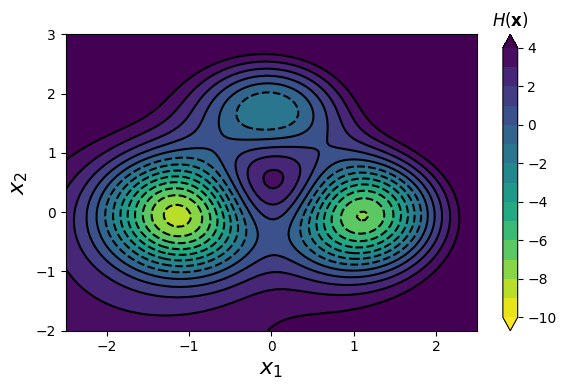

In [5]:
fig, axes = plt.subplots(figsize = (6,4))

plt.contour(x_illustrate, y_illustrate, E_illustrate,np.arange(-10, 5, 1),extend='both',colors='k');
plt.contourf(x_illustrate, y_illustrate, E_illustrate,np.arange(-10, 5, 1),extend='both',cmap='viridis_r');
clb = plt.colorbar()
clb.ax.set_title(r'$H(\mathbf{x})$')

my_font_size = 16 
plt.xlabel(r"$x_1$", fontsize = my_font_size)
plt.ylabel(r"$x_2$", fontsize = my_font_size)

plt.tight_layout()
# plt.savefig("images/double_well_potential.png", dpi=600, transparent=False)
plt.show()

## Hyperparameter optimization visualization using brute force

This notebook visualizes the results of the hyperparameter optimization. The results are plotted in 4 graphs, much like figure 3 of the paper about the CS230 project.The distribution of the latent space conversion to real space is plotted more extensively by drawing 500000 samples from latent space and converting these to real space coordinates. The number density of the drawn samples is visualized using a colourmap which scales logarithmically.

In [6]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005],[0.001,0.001]]
iterations=[[100,100],[100,25],[100,50],[100,75],[200,50],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100],[200,50]]
width_network=[100]
sample_size=[[1000,1000]]
i=0

datadir="/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/" #define the directory where the data is saved

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                file=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv"
                
                if (os.path.exists(datadir+file)):

                    i+=1

                    #get the data from the files created in the data generation notebook
                    
                    coords_state_a=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",delimiter=",")
                    coords_state_b=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",delimiter=",")
                    z=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",delimiter=",")
                    x=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",delimiter=",")
                    z1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",delimiter=",")
                    x1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",delimiter=",")

                    globals()[f"fig{i}"], globals()[f"axes{i}"] = plt.subplots(2, 3, figsize = (10,6))

                    fig=globals()[f"fig{i}"]
                    axes=globals()[f"axes{i}"]

                    # visualize data after training by example

                    # plot data sampled in real space 
                    plt.subplot(231)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(232)
                    plt.scatter(z[:, 0], z[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    plt.subplot(233)
                    plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')
                    
                    # visualize data after training by energy

                    # plot data sampled in real space 
                    plt.subplot(234)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(235)
                    plt.scatter(z1[:, 0], z1[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back
                    k = kde.gaussian_kde(x1.T)
                    xi, yi = np.mgrid[x1[:,0].min():x1[:,0].max():nbins*1j, x1[:,1].min():x1[:,1].max():nbins*1j]
                    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                    # sample 1000 points from prior and transform back 
                    plt.subplot(236)
                    # plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    b=nbins*nbins
                    plt.pcolormesh(xi, yi, zi.reshape(xi.shape)*b, norm=colors.LogNorm(vmin=1,vmax=(zi*b).reshape(xi.shape).max()), shading="gouraud",cmap=plt.get_cmap('viridis'))
                    plt.contour(xi, yi, zi.reshape(xi.shape) )

                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    st = fig.suptitle(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}", fontsize="x-large")
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.85)

                    plt.savefig(fname=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}.png", dpi=300, facecolor='white')

                else:

                    print(datadir + file + "does not exist")
                

/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/lr=0.001_0.00075_width=100_size=1000_1000_iter=100_100_coor_state_a.csvdoes not exist
/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/lr=0.001_0.00075_width=100_size=1000_1000_iter=100_25_coor_state_a.csvdoes not exist
/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/lr=0.001_0.00075_width=100_size=1000_1000_iter=100_50_coor_state_a.csvdoes not exist
/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/lr=0.001_0.00075_width=100_size=1000_1000_iter=100_75_coor_state_a.csvdoes not exist
/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/lr=0.001_0.00075_width=100_size=1000_1000_iter=200_50_coor_state_a.csvdoes not exist
/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/lr=0.001_0.00075

In [ ]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005],[0.001,0.001]]
# width_network=[128,256,512,1024]
# sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,25],[100,50],[100,75],[200,50],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100],[200,50]]
width_network=[100]
sample_size=[[1000,5000]]
i=0

datadir="/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/"

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                file=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv"
                
                if (os.path.exists(datadir+file)):

                    i+=1

                    coords_state_a=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",delimiter=",")
                    coords_state_b=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",delimiter=",")
                    z=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",delimiter=",")
                    x=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",delimiter=",")
                    z1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",delimiter=",")
                    x1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",delimiter=",")

                    globals()[f"fig{i}"], globals()[f"axes{i}"] = plt.subplots(2, 3, figsize = (10,6))

                    fig=globals()[f"fig{i}"]
                    axes=globals()[f"axes{i}"]

                    # plot data sampled in real space 
                    plt.subplot(231)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(232)
                    plt.scatter(z[:, 0], z[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    plt.subplot(233)
                    plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    # plot data sampled in real space 
                    plt.subplot(234)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(235)
                    plt.scatter(z1[:, 0], z1[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    k = kde.gaussian_kde(x1.T)
                    xi, yi = np.mgrid[x1[:,0].min():x1[:,0].max():nbins*1j, x1[:,1].min():x1[:,1].max():nbins*1j]
                    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                    # sample 1000 points from prior and transform back 
                    plt.subplot(236)
                    # plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    b=nbins*nbins
                    plt.pcolormesh(xi, yi, zi.reshape(xi.shape)*b, norm=colors.LogNorm(vmin=1,vmax=(zi*b).reshape(xi.shape).max()), shading="gouraud",cmap=plt.get_cmap('viridis'))
                    plt.contour(xi, yi, zi.reshape(xi.shape) )

                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    st = fig.suptitle(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}", fontsize="x-large")
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.85)

                    plt.savefig(fname=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}.png", dpi=300, facecolor='white')

                else:

                    print(datadir + file + "does not exist")
                

In [ ]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005],[0.001,0.001]]
# width_network=[128,256,512,1024]
# sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,25],[100,50],[100,75],[200,50],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100],[200,50]]
width_network=[100]
sample_size=[[5000,1000]]
i=0

datadir="/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/"

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                file=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv"
                
                if (os.path.exists(datadir+file)):

                    i+=1

                    coords_state_a=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",delimiter=",")
                    coords_state_b=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",delimiter=",")
                    z=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",delimiter=",")
                    x=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",delimiter=",")
                    z1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",delimiter=",")
                    x1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",delimiter=",")

                    globals()[f"fig{i}"], globals()[f"axes{i}"] = plt.subplots(2, 3, figsize = (10,6))

                    fig=globals()[f"fig{i}"]
                    axes=globals()[f"axes{i}"]

                    # plot data sampled in real space 
                    plt.subplot(231)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(232)
                    plt.scatter(z[:, 0], z[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    plt.subplot(233)
                    plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    # plot data sampled in real space 
                    plt.subplot(234)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(235)
                    plt.scatter(z1[:, 0], z1[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    k = kde.gaussian_kde(x1.T)
                    xi, yi = np.mgrid[x1[:,0].min():x1[:,0].max():nbins*1j, x1[:,1].min():x1[:,1].max():nbins*1j]
                    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                    # sample 1000 points from prior and transform back 
                    plt.subplot(236)
                    # plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    b=nbins*nbins
                    plt.pcolormesh(xi, yi, zi.reshape(xi.shape)*b, norm=colors.LogNorm(vmin=1,vmax=(zi*b).reshape(xi.shape).max()), shading="gouraud",cmap=plt.get_cmap('viridis'))
                    plt.contour(xi, yi, zi.reshape(xi.shape) )

                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    st = fig.suptitle(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}", fontsize="x-large")
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.85)

                    plt.savefig(fname=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}.png", dpi=300, facecolor='white')

                else:

                    print(datadir + file + "does not exist")
                

In [ ]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005],[0.001,0.001]]
# width_network=[128,256,512,1024]
# sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,25],[100,50],[100,75],[200,50],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100],[200,50]]
width_network=[128]
sample_size=[[1000,1000]]
i=0

datadir="/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/"

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                file=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv"
                
                if (os.path.exists(datadir+file)):

                    i+=1

                    coords_state_a=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",delimiter=",")
                    coords_state_b=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",delimiter=",")
                    z=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",delimiter=",")
                    x=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",delimiter=",")
                    z1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",delimiter=",")
                    x1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",delimiter=",")

                    globals()[f"fig{i}"], globals()[f"axes{i}"] = plt.subplots(2, 3, figsize = (10,6))

                    fig=globals()[f"fig{i}"]
                    axes=globals()[f"axes{i}"]

                    # plot data sampled in real space 
                    plt.subplot(231)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(232)
                    plt.scatter(z[:, 0], z[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    plt.subplot(233)
                    plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    # plot data sampled in real space 
                    plt.subplot(234)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(235)
                    plt.scatter(z1[:, 0], z1[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    k = kde.gaussian_kde(x1.T)
                    xi, yi = np.mgrid[x1[:,0].min():x1[:,0].max():nbins*1j, x1[:,1].min():x1[:,1].max():nbins*1j]
                    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                    # sample 1000 points from prior and transform back 
                    plt.subplot(236)
                    # plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    b=nbins*nbins
                    plt.pcolormesh(xi, yi, zi.reshape(xi.shape)*b, norm=colors.LogNorm(vmin=1,vmax=(zi*b).reshape(xi.shape).max()), shading="gouraud",cmap=plt.get_cmap('viridis'))
                    plt.contour(xi, yi, zi.reshape(xi.shape) )

                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    st = fig.suptitle(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}", fontsize="x-large")
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.85)

                    plt.savefig(fname=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}.png", dpi=300, facecolor='white')

                else:

                    print(datadir + file + "does not exist")
                

In [ ]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005],[0.001,0.001]]
# width_network=[128,256,512,1024]
# sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,25],[100,50],[100,75],[200,50],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100],[200,50]]
width_network=[128]
sample_size=[[1000,5000]]
i=0

datadir="/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/"

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                file=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv"
                
                if (os.path.exists(datadir+file)):

                    i+=1

                    coords_state_a=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",delimiter=",")
                    coords_state_b=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",delimiter=",")
                    z=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",delimiter=",")
                    x=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",delimiter=",")
                    z1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",delimiter=",")
                    x1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",delimiter=",")

                    globals()[f"fig{i}"], globals()[f"axes{i}"] = plt.subplots(2, 3, figsize = (10,6))

                    fig=globals()[f"fig{i}"]
                    axes=globals()[f"axes{i}"]

                    # plot data sampled in real space 
                    plt.subplot(231)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(232)
                    plt.scatter(z[:, 0], z[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    plt.subplot(233)
                    plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    # plot data sampled in real space 
                    plt.subplot(234)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(235)
                    plt.scatter(z1[:, 0], z1[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    k = kde.gaussian_kde(x1.T)
                    xi, yi = np.mgrid[x1[:,0].min():x1[:,0].max():nbins*1j, x1[:,1].min():x1[:,1].max():nbins*1j]
                    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                    # sample 1000 points from prior and transform back 
                    plt.subplot(236)
                    # plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    b=nbins*nbins
                    plt.pcolormesh(xi, yi, zi.reshape(xi.shape)*b, norm=colors.LogNorm(vmin=1,vmax=(zi*b).reshape(xi.shape).max()), shading="gouraud",cmap=plt.get_cmap('viridis'))
                    plt.contour(xi, yi, zi.reshape(xi.shape) )

                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    st = fig.suptitle(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}", fontsize="x-large")
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.85)

                    plt.savefig(fname=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}.png", dpi=300, facecolor='white')

                else:

                    print(datadir + file + "does not exist")
                

In [ ]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005],[0.001,0.001]]
# width_network=[128,256,512,1024]
# sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,25],[100,50],[100,75],[200,50],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100],[200,50]]
width_network=[128]
sample_size=[[5000,1000]]
i=0

datadir="/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/"

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                file=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv"
                
                if (os.path.exists(datadir+file)):

                    i+=1

                    coords_state_a=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",delimiter=",")
                    coords_state_b=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",delimiter=",")
                    z=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",delimiter=",")
                    x=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",delimiter=",")
                    z1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",delimiter=",")
                    x1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",delimiter=",")

                    globals()[f"fig{i}"], globals()[f"axes{i}"] = plt.subplots(2, 3, figsize = (10,6))

                    fig=globals()[f"fig{i}"]
                    axes=globals()[f"axes{i}"]

                    # plot data sampled in real space 
                    plt.subplot(231)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(232)
                    plt.scatter(z[:, 0], z[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    plt.subplot(233)
                    plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    # plot data sampled in real space 
                    plt.subplot(234)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(235)
                    plt.scatter(z1[:, 0], z1[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    k = kde.gaussian_kde(x1.T)
                    xi, yi = np.mgrid[x1[:,0].min():x1[:,0].max():nbins*1j, x1[:,1].min():x1[:,1].max():nbins*1j]
                    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                    # sample 1000 points from prior and transform back 
                    plt.subplot(236)
                    # plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    b=nbins*nbins
                    plt.pcolormesh(xi, yi, zi.reshape(xi.shape)*b, norm=colors.LogNorm(vmin=1,vmax=(zi*b).reshape(xi.shape).max()), shading="gouraud",cmap=plt.get_cmap('viridis'))
                    plt.contour(xi, yi, zi.reshape(xi.shape) )

                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    st = fig.suptitle(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}", fontsize="x-large")
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.85)

                    plt.savefig(fname=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}.png", dpi=300, facecolor='white')

                else:

                    print(datadir + file + "does not exist")
                

In [ ]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005],[0.001,0.001]]
# width_network=[128,256,512,1024]
# sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,25],[100,50],[100,75],[200,50],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100],[200,50]]
width_network=[256]
sample_size=[[1000,1000]]
i=0

datadir="/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/"

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                file=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv"
                
                if (os.path.exists(datadir+file)):

                    i+=1

                    coords_state_a=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",delimiter=",")
                    coords_state_b=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",delimiter=",")
                    z=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",delimiter=",")
                    x=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",delimiter=",")
                    z1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",delimiter=",")
                    x1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",delimiter=",")

                    globals()[f"fig{i}"], globals()[f"axes{i}"] = plt.subplots(2, 3, figsize = (10,6))

                    fig=globals()[f"fig{i}"]
                    axes=globals()[f"axes{i}"]

                    # plot data sampled in real space 
                    plt.subplot(231)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(232)
                    plt.scatter(z[:, 0], z[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    plt.subplot(233)
                    plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    # plot data sampled in real space 
                    plt.subplot(234)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(235)
                    plt.scatter(z1[:, 0], z1[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    k = kde.gaussian_kde(x1.T)
                    xi, yi = np.mgrid[x1[:,0].min():x1[:,0].max():nbins*1j, x1[:,1].min():x1[:,1].max():nbins*1j]
                    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                    # sample 1000 points from prior and transform back 
                    plt.subplot(236)
                    # plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    b=nbins*nbins
                    plt.pcolormesh(xi, yi, zi.reshape(xi.shape)*b, norm=colors.LogNorm(vmin=1,vmax=(zi*b).reshape(xi.shape).max()), shading="gouraud",cmap=plt.get_cmap('viridis'))
                    plt.contour(xi, yi, zi.reshape(xi.shape) )

                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    st = fig.suptitle(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}", fontsize="x-large")
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.85)

                    plt.savefig(fname=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}.png", dpi=300, facecolor='white')

                else:

                    print(datadir + file + "does not exist")
                

In [ ]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005],[0.001,0.001]]
# width_network=[128,256,512,1024]
# sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,25],[100,50],[100,75],[200,50],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100],[200,50]]
width_network=[256]
sample_size=[[1000,5000]]
i=0

datadir="/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/"

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                file=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv"
                
                if (os.path.exists(datadir+file)):

                    i+=1

                    coords_state_a=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",delimiter=",")
                    coords_state_b=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",delimiter=",")
                    z=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",delimiter=",")
                    x=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",delimiter=",")
                    z1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",delimiter=",")
                    x1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",delimiter=",")

                    globals()[f"fig{i}"], globals()[f"axes{i}"] = plt.subplots(2, 3, figsize = (10,6))

                    fig=globals()[f"fig{i}"]
                    axes=globals()[f"axes{i}"]

                    # plot data sampled in real space 
                    plt.subplot(231)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(232)
                    plt.scatter(z[:, 0], z[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    plt.subplot(233)
                    plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    # plot data sampled in real space 
                    plt.subplot(234)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(235)
                    plt.scatter(z1[:, 0], z1[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    k = kde.gaussian_kde(x1.T)
                    xi, yi = np.mgrid[x1[:,0].min():x1[:,0].max():nbins*1j, x1[:,1].min():x1[:,1].max():nbins*1j]
                    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                    # sample 1000 points from prior and transform back 
                    plt.subplot(236)
                    # plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    b=nbins*nbins
                    plt.pcolormesh(xi, yi, zi.reshape(xi.shape)*b, norm=colors.LogNorm(vmin=1,vmax=(zi*b).reshape(xi.shape).max()), shading="gouraud",cmap=plt.get_cmap('viridis'))
                    plt.contour(xi, yi, zi.reshape(xi.shape) )

                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    st = fig.suptitle(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}", fontsize="x-large")
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.85)

                    plt.savefig(fname=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}.png", dpi=300, facecolor='white')

                else:

                    print(datadir + file + "does not exist")
                

In [ ]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005],[0.001,0.001]]
# width_network=[128,256,512,1024]
# sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,25],[100,50],[100,75],[200,50],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100],[200,50]]
width_network=[256]
sample_size=[[5000,1000]]
i=0

datadir="/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/"

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                file=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv"
                
                if (os.path.exists(datadir+file)):

                    i+=1

                    coords_state_a=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",delimiter=",")
                    coords_state_b=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",delimiter=",")
                    z=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",delimiter=",")
                    x=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",delimiter=",")
                    z1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",delimiter=",")
                    x1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",delimiter=",")

                    globals()[f"fig{i}"], globals()[f"axes{i}"] = plt.subplots(2, 3, figsize = (10,6))

                    fig=globals()[f"fig{i}"]
                    axes=globals()[f"axes{i}"]

                    # plot data sampled in real space 
                    plt.subplot(231)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(232)
                    plt.scatter(z[:, 0], z[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    plt.subplot(233)
                    plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    # plot data sampled in real space 
                    plt.subplot(234)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(235)
                    plt.scatter(z1[:, 0], z1[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    k = kde.gaussian_kde(x1.T)
                    xi, yi = np.mgrid[x1[:,0].min():x1[:,0].max():nbins*1j, x1[:,1].min():x1[:,1].max():nbins*1j]
                    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                    # sample 1000 points from prior and transform back
                    plt.subplot(236)
                    # plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    b=nbins*nbins
                    plt.pcolormesh(xi, yi, zi.reshape(xi.shape)*b, norm=colors.LogNorm(vmin=1,vmax=(zi*b).reshape(xi.shape).max()), shading="gouraud",cmap=plt.get_cmap('viridis'))
                    plt.contour(xi, yi, zi.reshape(xi.shape) )

                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    st = fig.suptitle(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}", fontsize="x-large")
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.85)

                    plt.savefig(fname=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}.png", dpi=300, facecolor='white')

                else:

                    print(datadir + file + "does not exist")
                

In [ ]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005],[0.001,0.001]]
# width_network=[128,256,512,1024]
# sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,25],[100,50],[100,75],[200,50],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100],[200,50]]
width_network=[512]
sample_size=[[1000,1000]]
i=0

datadir="/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/"

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                file=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv"
                
                if (os.path.exists(datadir+file)):

                    i+=1

                    coords_state_a=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",delimiter=",")
                    coords_state_b=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",delimiter=",")
                    z=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",delimiter=",")
                    x=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",delimiter=",")
                    z1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",delimiter=",")
                    x1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",delimiter=",")

                    globals()[f"fig{i}"], globals()[f"axes{i}"] = plt.subplots(2, 3, figsize = (10,6))

                    fig=globals()[f"fig{i}"]
                    axes=globals()[f"axes{i}"]

                    # plot data sampled in real space 
                    plt.subplot(231)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(232)
                    plt.scatter(z[:, 0], z[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    plt.subplot(233)
                    plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    # plot data sampled in real space 
                    plt.subplot(234)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(235)
                    plt.scatter(z1[:, 0], z1[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    k = kde.gaussian_kde(x1.T)
                    xi, yi = np.mgrid[x1[:,0].min():x1[:,0].max():nbins*1j, x1[:,1].min():x1[:,1].max():nbins*1j]
                    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                    # sample 1000 points from prior and transform back 
                    plt.subplot(236)
                    # plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    b=nbins*nbins
                    plt.pcolormesh(xi, yi, zi.reshape(xi.shape)*b, norm=colors.LogNorm(vmin=1,vmax=(zi*b).reshape(xi.shape).max()), shading="gouraud",cmap=plt.get_cmap('viridis'))
                    plt.contour(xi, yi, zi.reshape(xi.shape) )

                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    st = fig.suptitle(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}", fontsize="x-large")
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.85)

                    plt.savefig(fname=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}.png", dpi=300, facecolor='white')

                else:

                    print(datadir + file + "does not exist")
                

In [ ]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005],[0.001,0.001]]
# width_network=[128,256,512,1024]
# sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,25],[100,50],[100,75],[200,50],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100],[200,50]]
width_network=[512]
sample_size=[[1000,5000]]
i=0

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                file=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv"
                
                if (os.path.exists(datadir+file)):

                    i+=1

                    coords_state_a=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",delimiter=",")
                    coords_state_b=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",delimiter=",")
                    z=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",delimiter=",")
                    x=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",delimiter=",")
                    z1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",delimiter=",")
                    x1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",delimiter=",")

                    globals()[f"fig{i}"], globals()[f"axes{i}"] = plt.subplots(2, 3, figsize = (10,6))

                    fig=globals()[f"fig{i}"]
                    axes=globals()[f"axes{i}"]

                    # plot data sampled in real space 
                    plt.subplot(231)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(232)
                    plt.scatter(z[:, 0], z[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    plt.subplot(233)
                    plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    # plot data sampled in real space 
                    plt.subplot(234)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(235)
                    plt.scatter(z1[:, 0], z1[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    k = kde.gaussian_kde(x1.T)
                    xi, yi = np.mgrid[x1[:,0].min():x1[:,0].max():nbins*1j, x1[:,1].min():x1[:,1].max():nbins*1j]
                    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                    # sample 1000 points from prior and transform back 
                    plt.subplot(236)
                    # plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    b=nbins*nbins
                    plt.pcolormesh(xi, yi, zi.reshape(xi.shape)*b, norm=colors.LogNorm(vmin=1,vmax=(zi*b).reshape(xi.shape).max()), shading="gouraud",cmap=plt.get_cmap('viridis'))
                    plt.contour(xi, yi, zi.reshape(xi.shape) )

                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    st = fig.suptitle(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}", fontsize="x-large")
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.85)

                    plt.savefig(fname=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}.png", dpi=300, facecolor='white')

                else:

                    print(datadir + file + "does not exist")
                

In [ ]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005],[0.001,0.001]]
# width_network=[128,256,512,1024]
# sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,25],[100,50],[100,75],[200,50],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100],[200,50]]
width_network=[512]
sample_size=[[5000,1000]]
i=0

datadir="/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/"

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                file=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv"
                
                if (os.path.exists(datadir+file)):

                    i+=1

                    coords_state_a=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",delimiter=",")
                    coords_state_b=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",delimiter=",")
                    z=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",delimiter=",")
                    x=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",delimiter=",")
                    z1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",delimiter=",")
                    x1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",delimiter=",")

                    globals()[f"fig{i}"], globals()[f"axes{i}"] = plt.subplots(2, 3, figsize = (10,6))

                    fig=globals()[f"fig{i}"]
                    axes=globals()[f"axes{i}"]

                    # plot data sampled in real space 
                    plt.subplot(231)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(232)
                    plt.scatter(z[:, 0], z[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    plt.subplot(233)
                    plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    # plot data sampled in real space 
                    plt.subplot(234)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(235)
                    plt.scatter(z1[:, 0], z1[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    k = kde.gaussian_kde(x1.T)
                    xi, yi = np.mgrid[x1[:,0].min():x1[:,0].max():nbins*1j, x1[:,1].min():x1[:,1].max():nbins*1j]
                    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                    # sample 1000 points from prior and transform back 
                    plt.subplot(236)
                    # plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    b=nbins*nbins
                    plt.pcolormesh(xi, yi, zi.reshape(xi.shape)*b, norm=colors.LogNorm(vmin=1,vmax=(zi*b).reshape(xi.shape).max()), shading="gouraud",cmap=plt.get_cmap('viridis'))
                    plt.contour(xi, yi, zi.reshape(xi.shape) )

                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    st = fig.suptitle(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}", fontsize="x-large")
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.85)

                    plt.savefig(fname=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}.png", dpi=300, facecolor='white')

                else:

                    print(datadir + file + "does not exist")
                

In [ ]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005],[0.001,0.001]]
# width_network=[128,256,512,1024]
# sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,25],[100,50],[100,75],[200,50],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100],[200,50]]
width_network=[1024]
sample_size=[[1000,1000]]
i=0

datadir="/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/"

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                file=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv"
                
                if (os.path.exists(datadir+file)):

                    i+=1

                    coords_state_a=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",delimiter=",")
                    coords_state_b=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",delimiter=",")
                    z=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",delimiter=",")
                    x=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",delimiter=",")
                    z1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",delimiter=",")
                    x1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",delimiter=",")

                    globals()[f"fig{i}"], globals()[f"axes{i}"] = plt.subplots(2, 3, figsize = (10,6))

                    fig=globals()[f"fig{i}"]
                    axes=globals()[f"axes{i}"]

                    # plot data sampled in real space 
                    plt.subplot(231)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(232)
                    plt.scatter(z[:, 0], z[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    plt.subplot(233)
                    plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    # plot data sampled in real space 
                    plt.subplot(234)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(235)
                    plt.scatter(z1[:, 0], z1[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    k = kde.gaussian_kde(x1.T)
                    xi, yi = np.mgrid[x1[:,0].min():x1[:,0].max():nbins*1j, x1[:,1].min():x1[:,1].max():nbins*1j]
                    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                    # sample 1000 points from prior and transform back 
                    plt.subplot(236)
                    # plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    b=nbins*nbins
                    plt.pcolormesh(xi, yi, zi.reshape(xi.shape)*b, norm=colors.LogNorm(vmin=1,vmax=(zi*b).reshape(xi.shape).max()), shading="gouraud",cmap=plt.get_cmap('viridis'))
                    plt.contour(xi, yi, zi.reshape(xi.shape) )

                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    st = fig.suptitle(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}", fontsize="x-large")
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.85)

                    plt.savefig(fname=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}.png", dpi=300, facecolor='white')

                else:

                    print(datadir + file + "does not exist")
                

In [ ]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005],[0.001,0.001]]
# width_network=[128,256,512,1024]
# sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,25],[100,50],[100,75],[200,50],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100],[200,50]]
width_network=[1024]
sample_size=[[1000,5000]]
i=0

datadir="/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/"

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                file=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv"
                
                if (os.path.exists(datadir+file)):

                    i+=1

                    coords_state_a=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",delimiter=",")
                    coords_state_b=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",delimiter=",")
                    z=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",delimiter=",")
                    x=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",delimiter=",")
                    z1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",delimiter=",")
                    x1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",delimiter=",")

                    globals()[f"fig{i}"], globals()[f"axes{i}"] = plt.subplots(2, 3, figsize = (10,6))

                    fig=globals()[f"fig{i}"]
                    axes=globals()[f"axes{i}"]

                    # plot data sampled in real space 
                    plt.subplot(231)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(232)
                    plt.scatter(z[:, 0], z[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    plt.subplot(233)
                    plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    # plot data sampled in real space 
                    plt.subplot(234)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(235)
                    plt.scatter(z1[:, 0], z1[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    k = kde.gaussian_kde(x1.T)
                    xi, yi = np.mgrid[x1[:,0].min():x1[:,0].max():nbins*1j, x1[:,1].min():x1[:,1].max():nbins*1j]
                    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                    # sample 1000 points from prior and transform back 
                    plt.subplot(236)
                    # plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    b=nbins*nbins
                    plt.pcolormesh(xi, yi, zi.reshape(xi.shape)*b, norm=colors.LogNorm(vmin=1,vmax=(zi*b).reshape(xi.shape).max()), shading="gouraud",cmap=plt.get_cmap('viridis'))
                    plt.contour(xi, yi, zi.reshape(xi.shape) )

                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    st = fig.suptitle(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}", fontsize="x-large")
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.85)

                    plt.savefig(fname=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}.png", dpi=300, facecolor='white')

                else:

                    print(datadir + file + "does not exist")
                

In [ ]:
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005],[0.001,0.001]]
# width_network=[128,256,512,1024]
# sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,25],[100,50],[100,75],[200,50],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100],[200,50]]
width_network=[1024]
sample_size=[[5000,1000]]
i=0

datadir="/Users/toon/Downloads/MLFC_project-BG-HFW_TVG-main/project/experiments/Data/Results_20_05_23/"

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                file=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv"
                
                if (os.path.exists(datadir+file)):

                    i+=1

                    coords_state_a=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",delimiter=",")
                    coords_state_b=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",delimiter=",")
                    z=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",delimiter=",")
                    x=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",delimiter=",")
                    z1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",delimiter=",")
                    x1=np.genfromtxt(datadir+f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",delimiter=",")

                    globals()[f"fig{i}"], globals()[f"axes{i}"] = plt.subplots(2, 3, figsize = (10,6))

                    fig=globals()[f"fig{i}"]
                    axes=globals()[f"axes{i}"]

                    # plot data sampled in real space 
                    plt.subplot(231)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(232)
                    plt.scatter(z[:, 0], z[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    plt.subplot(233)
                    plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    # plot data sampled in real space 
                    plt.subplot(234)
                    plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
                    plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X \sim p(X)$')

                    # sampling from the multivariate gaussian with zero mean and unit variance
                    plt.subplot(235)
                    plt.scatter(z1[:, 0], z1[:, 1])
                    plt.xlim([-8,8])
                    plt.ylim([-8,8])
                    plt.title(r'$z \sim p(z)$')

                    # sample 1000 points from prior and transform back 
                    k = kde.gaussian_kde(x1.T)
                    xi, yi = np.mgrid[x1[:,0].min():x1[:,0].max():nbins*1j, x1[:,1].min():x1[:,1].max():nbins*1j]
                    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                    # sample 1000 points from prior and transform back 
                    plt.subplot(236)
                    # plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
                    b=nbins*nbins
                    plt.pcolormesh(xi, yi, zi.reshape(xi.shape)*b, norm=colors.LogNorm(vmin=1,vmax=(zi*b).reshape(xi.shape).max()), shading="gouraud",cmap=plt.get_cmap('viridis'))
                    plt.contour(xi, yi, zi.reshape(xi.shape) )

                    plt.xlim([-4,4])
                    plt.ylim([-4,4])
                    plt.title(r'$X = g(z)$')

                    st = fig.suptitle(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}", fontsize="x-large")
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.85)

                    plt.savefig(fname=f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}.png", dpi=300, facecolor='white')

                else:

                    print(datadir + file + "does not exist")
                

In [ ]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(223)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X \sim p(X)$')

# sampling from the multivariate gaussian with zero mean and unit variance
plt.subplot(222)
plt.scatter(z1[:, 0], z1[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z \sim p(z)$')

# sample 1000 points from prior and transform back 
plt.subplot(224)
plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X = g(z)$')

## Boltzmann generator training
We would now like to infer the energy landscape through direct sampling of a learned latent space description of this sytem. We achieve this by training a Boltzmann generator on the given input data. We begin by defining our network architecture, using the specifications given on pg. 4 of the SI of Noe et al.: 

In [ ]:
n_hidden = 256  # number of nodes in each hidden layer
temperature = 1.0 # doesn't do anything
l_hidden = 3   # number of hidden layers 

There the training schedule is also specified. Let "1" in the following denote the first set of iterations (where only the ML loss is used) while "2" refers to the second second of iterations (where both the ML and KL loss is utilized): 

In [ ]:
iter1 = 100
iter2 = 200

batch_size1 = 1000 # less than 1000 does not seem to converge 
batch_size2 = 50000

lr1 = 0.001 # could not get monotonic decrease of loss with largest learning rates when using standard gradient descent. 
lr2 = 0.0001

We can now create the Boltzmann generator network: 

In [ ]:
# Parameter Debugging
n_hidden = 256

# Define our model (the triple well potential)
triplewell = TripleWell()

# Define the network architecture
nets = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh()) # net s
nett = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2)) # net t
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)) # 6x2 matrix. len(masks) = 6 = num subblocks.
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))      # so we have a total of 3 neural blocks (see fig. 1 of boltzmann generators paper)
model = net.RealNVP(nets, nett, masks, prior, triplewell, (2,))

### Training by example
Time to train the model. We first "train by example" by computing only the ML loss. This loss essentially maximizes the likelihood of our input configurations in the latent space Gaussian distribution. 

In contrast, the KL loss promotes sampling of low-energy states; it also includes an entropic contribution to penalize repeated sampling of the same stable state. 

In [ ]:
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr1) 
training_set = training_set.astype('float32')
trainloader = data.DataLoader(dataset=training_set, batch_size=batch_size1)

losses = [] # for visualizing loss as a function of iteration number rather than epoch number
t = 0 # iteration count

while t < iter1:
    for batch in trainloader:  

        # Custom ML loss function
        loss = model.loss_ml(batch) 
        losses.append(loss.item()) # save values for plotting later 
    
        # Training
        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1 # iteration count
        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

# Visualize loss
fig = go.Figure() # plotly reference: https://plot.ly/python/line-charts/
fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=losses,
                    mode='lines',
                    name='lines'))

fig.update_layout(yaxis_title='Loss',
                   xaxis_title='Iteration #')

It appears from the above plot of the ML loss that the model has been succesfully trained. Let's confirm this by now sampling from the learned latent space distribution and trying to then infer the energy landscape in real space from these samples. 

In [ ]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(223)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X \sim p(X)$')

# sample from x and transform to z 
z_md_a = model.f(torch.from_numpy(coords_state_a.astype('float32')))[0].detach().numpy()
z_md_b = model.f(torch.from_numpy(coords_state_b.astype('float32')))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue')
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z = f(X)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z, x = model.sample(2000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z \sim p(z)$')

# sample 1000 points from prior and transform back 
plt.subplot(224)
plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X = g(z)$')

In [ ]:
plt.hist(model.energies,bins=40)
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.show()

### Training by energy
We will now train with the KL loss to teach the network to focus on both low energy states. 

In [ ]:
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr2) 
training_set_2 = (z.astype('float32'))
trainloader_2 = data.DataLoader(dataset=training_set_2, batch_size=batch_size2)

t = iter1

while t < iter1 + iter2:
    for batch_z in trainloader_2:  
        # KL loss function
        loss = model.loss_kl(batch_z)
        losses.append(loss.item()) # save values for plotting later 
    
        # Training on KL loss
        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1 # iteration count

        if 

        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

# Visualize loss
fig = go.Figure() # plotly reference: https://plot.ly/python/line-charts/
fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=losses,
                    mode='lines',
                    name='lines'))

fig.update_layout(yaxis_title='Loss', xaxis_title='Iteration #')

In [ ]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(223)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X \sim p(X)$')

# sample from x and transform to z 
z_md_a = model.f(torch.from_numpy(coords_state_a.astype('float32')))[0].detach().numpy()
z_md_b = model.f(torch.from_numpy(coords_state_b.astype('float32')))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue')
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z = f(X)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z1, x1 = model.sample(500000)
plt.subplot(222)
plt.scatter(z1[:, 0], z1[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z \sim p(z)$')

# sample 1000 points from prior and transform back 
plt.subplot(224)
plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X = g(z)$')

In [ ]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (8,8))
my_font_size = 16 # for paper
my_s = 2

# plot data sampled in real space 
plt.subplot(223)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X \sim p(X)$', fontsize = my_font_size)

# sample from x and transform to z 
z_md_a = model.f(torch.from_numpy(coords_state_a.astype('float32')))[0].detach().numpy()
z_md_b = model.f(torch.from_numpy(coords_state_b.astype('float32')))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue')
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z = f(X)$', fontsize = my_font_size)

# sampling from the multivariate gaussian with zero mean and unit variance
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z \sim p(z)$', fontsize = my_font_size)

# sample 1000 points from prior and transform back 
x = model.g(torch.from_numpy(z))[0].detach().numpy()
plt.subplot(224)
plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X = g(z)$', fontsize = my_font_size)

fig.tight_layout()
# plt.savefig("images/double_well_results2x2.png", dpi=600, transparent=False)

In [ ]:
fig, axes = plt.subplots(figsize = (6,4))

plt.contour(x_illustrate, y_illustrate, E_illustrate,np.arange(-10, 5, 1),extend='both',colors='k');
clb = plt.colorbar()
clb.ax.set_title(r'$H(\mathbf{x})$')

my_font_size = 16 
plt.xlabel(r"$x_1$", fontsize = my_font_size)
plt.ylabel(r"$x_2$", fontsize = my_font_size)
plt.scatter(x[:, 0], x[:, 1], c='r', alpha=0.1) 
plt.xlim([-2.5,2.5])
plt.ylim([-2,3])

plt.tight_layout()
# plt.savefig("images/double_well_potential.png", dpi=600, transparent=False)
plt.show()

For the purposes of the report, we will visualize the data in a different order: 

In [ ]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (8,8))
my_font_size = 16 # for paper
my_s = 2

# plot data sampled in real space 
plt.subplot(223)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X \sim p(X)$', fontsize = my_font_size)

# sample from x and transform to z 
z_md_a = model.f(torch.from_numpy(coords_state_a.astype('float32')))[0].detach().numpy()
z_md_b = model.f(torch.from_numpy(coords_state_b.astype('float32')))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue')
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z = f(X)$', fontsize = my_font_size)

# sampling from the multivariate gaussian with zero mean and unit variance
z, x = model.sample(100000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z \sim p(z)$', fontsize = my_font_size)

# sample 1000 points from prior and transform back 
x = model.g(torch.from_numpy(z))[0].detach().numpy()
plt.subplot(224)
plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X = g(z)$', fontsize = my_font_size)

fig.tight_layout()
# plt.savefig("images/double_well_results2x2.png", dpi=600, transparent=False)

In [ ]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(1,4, figsize = (12,3)) # width x height in inches
my_font_size = 16 # for paper
my_s = 2

# plot data sampled in real space 
plt.subplot(141)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r',s = my_s)
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon',s = my_s)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X \sim p(X)$', fontsize = my_font_size)

# sample from x and transform to z 
plt.subplot(142)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue',s = my_s)
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue',s = my_s)
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z = f(X)$', fontsize = my_font_size)

# sampling from the multivariate gaussian with zero mean and unit variance
plt.subplot(143)
plt.scatter(z[:, 0], z[:, 1],s = my_s)
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z \sim p(z)$', fontsize = my_font_size)

# sample 1000 points from prior and transform back 
plt.subplot(144)
plt.scatter(x[:, 0], x[:, 1], c='r',s = my_s) # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X = g(z)$', fontsize = my_font_size)

fig.tight_layout()
plt.savefig("images/double_well_results.png", dpi=600, transparent=False)

In [ ]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 1, figsize = (8,4))
my_font_size = 16 # for paper
my_s = 2

# plot data sampled in real space 
plt.subplot(121)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X \sim p(X)$', fontsize = my_font_size)

# sample from x and transform to z 
z_md_a = model.f(torch.from_numpy(coords_state_a.astype('float32')))[0].detach().numpy()
z_md_b = model.f(torch.from_numpy(coords_state_b.astype('float32')))[0].detach().numpy()
plt.subplot(122)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue')
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z = f(X)$', fontsize = my_font_size)

fig.tight_layout()
plt.savefig("images/double_well_results_2x1_top.png", dpi=600, transparent=False)
fig, axes = plt.subplots(2, 1, figsize = (8,4))

# sampling from the multivariate gaussian with zero mean and unit variance
plt.subplot(121)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z \sim p(z)$', fontsize = my_font_size)

# sample 1000 points from prior and transform back 
x = model.g(torch.from_numpy(z))[0].detach().numpy()
plt.subplot(122)
plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X = g(z)$', fontsize = my_font_size)

fig.tight_layout()
plt.savefig("images/double_well_results_2x1_bottom.png", dpi=600, transparent=False)

### Free Energy
With our model now correctly generating the Boltzmann distribution (bottom right), we can utilize it to calculate the free energy as a function of the reaction coordinate for this system (the coordinate $x_1$). The Boltzmann distribution is given by: 

$p(x) = \exp(-f(x))$ so $f = -\log(p(x))$ where $f$ denote free energy. 

Steps:

1) Histogram the obtained samples to estimate probs

2) Filter probabilities to avoid single-sample, low-prob. states that are likely just noise

3) Calculate free energy

4) Shift free energy to lowest well reference state (we only get relative $f - f_0$)


Note: The smoothness of the average can be improved by generating more sample points.

In [ ]:
z_fe, x_fe = model.sample(500000)

In [ ]:
x1 = x_fe[:,0]
x2 = x_fe[:,1]

counts, bins = np.histogram(x1, bins = 200)
anchors = (bins[1:] + bins[:-1]) / 2

probs = counts / np.sum(counts)

anchors = anchors[np.where(probs > 0.0001)]
probs = probs[np.where(probs > 0.0001)]

f = -np.log(probs)
fn = f - np.min(f)

In [ ]:
# Visualize the results
plt.scatter(anchors, fn) 

plt.xlabel("$x_1$")
plt.ylabel(r"$(f - f_0) / k_B T$")

plt.show()

For the simple double well potential, we can also calculate this free energy analytically. The partition function $Z$ is given by: 
$$ \ln Z(x_1) = \sqrt{2\pi}\big( x_1^4 - 6*x_1^2 + x_1 \big)$$
from which we can calculate the free energy via $f=-k_B T \ln Z$

In [ ]:
fig, axes = plt.subplots(figsize = (6,4))
x1 = np.linspace(-2.5,2.5,1000)
logz = (x1**4 - 6*x1**2 + x1) + 11

plt.plot(x1,logz)
plt.scatter(anchors, fn,color='orange') 

plt.xlabel("$x_1$", fontsize = my_font_size)
plt.ylabel(r"$(f - f_0) / k_B T$", fontsize = my_font_size)

plt.tight_layout()
plt.savefig("images/double_well_fe.png", dpi=600, transparent=False)
plt.show()

## Notes
- List of Plotly colors: https://community.plot.ly/t/plotly-colours-list/11730/3